In [1]:
import torch
import numpy as np
import math 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
import itertools
if torch.cuda.is_available():  
    device = "cuda" 
else:
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0   

## Initialization
def adjust_neuron_position(my_model,target=None):
    counter = 0 
    positions = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]).to(device)
    neuron_num = my_model.fc1.bias.size(0)
    for i in range(neuron_num): 
        w = my_model.fc1.weight.data[i:i+1,:]
        b = my_model.fc1.bias.data[i]
        values = torch.matmul(positions,w.T) # + b
        left_end = - torch.max(values)
        right_end = - torch.min(values) 
        off_set = (right_end - left_end)/1000 
        if b <= left_end + off_set: # nearly vanishing
            b = torch.rand(1).to(device)*(right_end - left_end - off_set*2) + left_end + off_set 
            my_model.fc1.bias.data[i] = b 
        if b >= right_end - off_set: # nearly nonvanishing everywhere
            if counter < 3:
                counter += 1
            else: # 3 or more 
                b = torch.rand(1).to(device)*(right_end - left_end - off_set*2) + left_end + off_set
                my_model.fc1.bias.data[i] = b 
    return my_model

In [2]:
def show_convergence_order2(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    # f_write.write('randomized dictionary size: {}\n'.format(N))
    # f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order & \t $ | u -u_n |_{H^1}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")

            # print("*")
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
            # f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            # f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    # f_write.write("\n")
    # f_write.close()

## Qaudrature rules

In [3]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights.to(device), integration_points.to(device)

def PiecewiseGQ3D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

    """
    Parameters
    ----------
    target : 
        Target function 
    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature
    """

    # print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,x,indexing='ij')).reshape(3,-1).T
    weight_list = np.array(np.meshgrid(w,w,w,indexing='ij'))
    weights =   (weight_list[0]*weight_list[1]*weight_list[2]).ravel() 

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**3,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**3 /8 

    integration_points = torch.tile(gauss_pts,(Nx**3,1))
    # print("shape of integration_points", integration_points.size())
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(3,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**3)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,3)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 

    return long_weights.to(device), integration_points.to(device)

def MonteCarlo_Sobol_dDim_weights_points(M ,d = 4):
    Sob_integral = torch.quasirandom.SobolEngine(dimension =d, scramble= False, seed=None) 
    integration_points = Sob_integral.draw(M).double() 
    integration_points = integration_points.to(device)
    weights = torch.ones(M,1).to(device)/M 
    return weights, integration_points 

def Neumann_boundary_quadrature_points_weights(M,d):
    def generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d):
        size_pts_bd = integration_points_bd.size(0) 
        gw_expand_bd_faces = torch.tile(gw_expand_bd,(2*d,1)) # 2d boundaries, 拉成长条

        integration_points_bd_faces = torch.zeros(2*d*integration_points_bd.size(0),d).to(device)
        for ind in range(d): 
            integration_points_bd_faces[2 *ind * size_pts_bd :(2 *ind +1) * size_pts_bd,ind:ind+1] = 0 
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,:ind] = integration_points_bd[:,:ind]
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,ind+1:] = integration_points_bd[:,ind:]

            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind:ind+1] = 1
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,:ind] = integration_points_bd[:,:ind]        
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind+1:] = integration_points_bd[:,ind:]
        return gw_expand_bd_faces, integration_points_bd_faces
    
    if d == 1: 
        print('dim',d)
        gw_expand_bd_faces = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd_faces = torch.tensor([0.,1.]).view(-1,1).to(device) 
    elif d == 2: 
        print('dim',d)
        gw_expand_bd, integration_points_bd = PiecewiseGQ1D_weights_points(0,1,8192*4, order = 3) 
    elif d == 3: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ2D_weights_points(50, order = 3) 
    elif d == 4: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ3D_weights_points(25, order = 3) 
        print('dim',d)
    else: 
        gw_expand_bd, integration_points_bd = MonteCarlo_Sobol_dDim_weights_points(M ,d = d)
        print('dim >=5 ')
    gw_expand_bd_faces, integration_points_bd_faces = generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d)
    return gw_expand_bd_faces.to(device), integration_points_bd_faces.to(device) 

## Linear layer minimization

In [4]:
def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 

def minimize_linear_layer_H1_explicit_assemble_efficient(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" ):

    # weights, integration_points = PiecewiseGQ2D_weights_points(Nx, order) 
    # integration_points.requires_grad_(True) 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    neuron_num = b.size(0) 
    dim = integration_points.size(1)  

    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
            basis_value_dy_col = torch.heaviside(integration_points @ w.t()+ b,ZERO) * w.t()[1:2,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
            basis_value_dy_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[1:2,:] 
    # elif activation == 'tanh': 
    #     basis_value_col = torch.tanh(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'gaussian':
    #     basis_value_col = Gaussian_activation(integration_points @ w.t()+ b)
    #     basis_value_dx_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'cosine':
    #     basis_value_col = cosine_activation(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:] 

    weighted_basis_value_col = basis_value_col * weights 
    jac1 = weighted_basis_value_col.t() @ basis_value_col  # mass matrix 

    # right hand side function 
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the mass matrix time taken: ", time.time()-start_time) 

    # neumann boundary condition 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            # pts_bd_ii = pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs += basis_value_bd_col.t() @ weighted_g_N

        
    start_time = time.time() 
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    weighted_basis_value_dy_col = basis_value_dy_col * weights
    jac2 = weighted_basis_value_dx_col.t() @ basis_value_dx_col + weighted_basis_value_dy_col.t() @ basis_value_dy_col 
    print("assembling the stiffness matrix time taken: ", time.time()-start_time)   
    jac = jac1 + jac2    
    
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 



## Newton solver for nonlinear Poisson 

In [5]:
    
## define the nonlinearity 
def nonlinear(v):
    return torch.sinh(v)

def nonlinear_prime(v):
    return torch.cosh(v)

def minimize_linear_layer_newton_method(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    dim = integration_points.size(1) 
    newton_iters = 20 

    # neumann boundary condition 
    rhs3 = 0 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs3 += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ w.t()+ b)**(model.k)
            rhs3 += basis_value_bd_col.t() @ weighted_g_N
    
    for i in range(newton_iters): 
        print("newton iteration: ", i+1) 
        coef_func = nonlinear_prime(model(integration_points).detach()) #changing after each newton iteration 
        jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

        # stiffness matrix 
        if activation == 'relu':
            basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
            if model.k == 1:  
                basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
                basis_value_dy_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[1:2,:] 
            else: 
                basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
                basis_value_dy_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[1:2,:]
        weighted_basis_value_dx_col = basis_value_dx_col * weights
        weighted_basis_value_dy_col = basis_value_dy_col * weights 
        jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col + weighted_basis_value_dy_col.t() @ basis_value_dy_col 
        jac = jac1 + jac2

        # f- u^3 term 
        rhs1 = weighted_basis_value_col.t() @ (target(integration_points) - nonlinear(model(integration_points).detach()) )

        # gradient term 
        if model!= None:
            dmy_model_dx1 = model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = model.evaluate_derivative(integration_points,2).detach()
            rhs2 =  - weighted_basis_value_dx_col.t() @ dmy_model_dx1  - weighted_basis_value_dy_col.t() @ dmy_model_dx2
            rhs = rhs1 + rhs2 +rhs3   
        else: 
            rhs = rhs1 +rhs3 

        # print("assembling the matrix time taken: ", time.time()-start_time) 
        start_time = time.time()    
        if solver == "cg": 
            sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
            sol = torch.tensor(sol).view(1,-1)
        elif solver == "direct": 
    #         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
            sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
        elif solver == "ls":
            sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
            # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
        # print("solving Ax = b time taken: ", time.time()-start_time)
        ## update the solution 
        print(sol.size())
        # print(sol)
        model.fc2.weight.data[0,:] += sol[0,:]

        # print("newton iteration: ", i) 
        sol_update_l2_norm = torch.norm(sol)
        nn_linear_layer_l2_norm = torch.norm(model.fc2.weight.data[0,:])
        residual_l2_norm = torch.norm(rhs) 
        # print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        tol = 1e-10
        print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        if sol_update_l2_norm < tol*nn_linear_layer_l2_norm or sol_update_l2_norm < tol or residual_l2_norm < tol*1e-2: 
            print("converged at iteration: ", i+1 )
            print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
            return model.fc2.weight.data[:,:] 
    print("Newton solver NOT converged at iteration!!! ")
    print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))

    return model.fc2.weight.data[:,:] 


## CGA for nonlinear Poisson 

In [6]:
def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor

# N_list = [10,20]
# Wb = generate_relu_dict2D(N_list).to(device)
# print(Wb.shape)

def generate_relu_dict2D_QMC(s,N0):
    # add this method to your notes... otherwise you will forget it 
    # Generate randomized Sobol sequence 
    
#     Sob = torch.quasirandom.SobolEngine(dimension =2, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double()

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    samples = torch.rand(s*N0,2) 
    
    T =torch.tensor([[2*pi,0],[0,2.84]])

    shift = torch.tensor([0,-1.42]) 

    samples = samples@T + shift 

    theta = samples[:,0].reshape(s*N0,1)
    W1 = torch.cos(theta)
    W2 = torch.sin(theta)
    W = torch.cat((W1,W2),1) # N1 x 2
    # b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1) 
    b = samples[:,1].reshape(s*N0,1)
    
    Wb = torch.cat((W,b),1) # N1 x 3 

    return Wb 


def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,gw_expand, integration_points,g_N,weights_bd, integration_points_bd,k):

    func_values = - target(integration_points)
    if my_model != None: 
        func_values = - target(integration_points) + nonlinear(my_model(integration_points).detach()) 

    weight_func_values = func_values*gw_expand  
    basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], ZERO) * relu_dict_parameters.t()[0:1,:]  
        dbasis_values_dx2 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], ZERO) * relu_dict_parameters.t()[1:2,:] 
        weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
        weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
        if my_model!= None:
            dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach() 
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[0:1,:] 
        dbasis_values_dx2 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[1:2,:] 
        weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
        weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
        if my_model!= None:
            dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach()

    #Neumann boundary condition
    output4 = 0 ##Todo 
    dim = integration_points.size(1) 
    size_pts_bd = int(integration_points_bd.size(0)/(2*dim))
    if g_N != None:
        bcs_N = g_N(dim)
        for ii, g_ii in bcs_N:
            # pts_bd_ii = pts_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            weighted_g_N = -g_ii(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:])* weights_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[2*ii*size_pts_bd:(2*ii+1)*size_pts_bd,:] @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2] )**(k)
            output4 += basis_value_bd_col.t() @ weighted_g_N

            weighted_g_N = g_ii(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:])* weights_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:]
            basis_value_bd_col = F.relu(integration_points_bd[(2*ii+1)*size_pts_bd:(2*ii+2)*size_pts_bd,:] @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k)
            output4 += basis_value_bd_col.t() @ weighted_g_N
        
    output1 = torch.matmul(basis_values,weight_func_values) #
    if my_model!= None:
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output3 = torch.matmul(weight_dbasis_values_dx2.t(), dmy_model_dx2) 
        output = torch.abs(output1 + output2 + output3 - output4) 
    else: 
        output = torch.abs(output1 - output4) 
    # output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
    neuron_index = torch.argmax(output.flatten())
    return neuron_index 

def L2_projection_init(model,sol,weights,integration_points,activation = 'relu', solver = 'direct'):
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
      
    rhs = jac[:,:-1] @ sol.t()

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    model.fc2.weight.data[0,:] = sol[0,:]  
    return model 

def CGANonlinearPoissonReLU2D(my_model,target,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k =1, rand_deter = 'deter', linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)
    dim = integration_points.size(1) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(999999,dim) #todo 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1).to(device)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    ## h1 error todo 
    if u_exact_grad != None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            err_h10[0] += torch.sum((grad_i(integration_points))**2 * gw_expand)**0.5
    
    start_time = time.time()
    solver = linear_solver

    N0 = np.prod(N_list)
    if rand_deter == 'deter':
        relu_dict_parameters = generate_relu_dict2D(N_list).to(device)
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        print("epoch: ",i+1, end = '\t')
        if rand_deter == 'rand':
            relu_dict_parameters = generate_relu_dict2D_QMC(1,N0).to(device) 
        
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,gw_expand, integration_points,g_N,weights_bd, integration_points_bd,k)

        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        ##todo 
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,gw_expand,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method(my_model,target,gw_expand, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]
        # sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,target,gw_expand, integration_points,activation = 'relu',solver = solver)

        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        model_values = my_model(integration_points).detach()
        # func_values = target(integration_points) - model_values
        # func_values_sqrd = func_values*func_values

        # L2 error ||u - u_n||
        diff_values_sqrd = (u_exact(integration_points) - model_values)**2 
        #Todo Done 
        err[i+1]= torch.sum(diff_values_sqrd*gw_expand)**0.5
        if u_exact_grad != None:
            for ii, grad_i in enumerate(u_grad): 
                my_model_dxi = my_model.evaluate_derivative(integration_points,ii+1).detach() 
                err_h10[i+1] += torch.sum((grad_i(integration_points) - my_model_dxi)**2 * gw_expand)**0.5

    print("time taken: ",time.time() - start_time)
    return err, err_h10.cpu(), my_model


In the following tests, we compare using deterministic dictionaries with using random dictionary for the following three target functions. 

- $\sin(\pi x_1) \sin(\pi x_2)$ 
- $\sin(4\pi x_1) \sin(8\pi x_2)$ 
- Gabor function 

## CGA experiments

## Gabor function 

dim 2
using linear solver:  direct
epoch:  1	newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:3.4046468279866515e-05 	 residual l2 norm: 0.010081950064865008 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:3.153143167433564e-12 	 residual l2 norm: 9.33718768969527e-10 
converged at iteration:  2
sol_update_l2_norm:3.153143167433564e-12 	 residual l2 norm: 9.33718768969527e-10 
epoch:  2	newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:0.00042251286888995954 	 residual l2 norm: 0.011936370808506116 
newton iteration:  2
torch.Size([1, 2])
sol_update_l2_norm:8.070565854580183e-11 	 residual l2 norm: 3.5177967570591455e-09 
converged at iteration:  2
sol_update_l2_norm:8.070565854580183e-11 	 residual l2 norm: 3.5177967570591455e-09 
epoch:  3	assembling the matrix time taken:  0.0001990795135498047
solving Ax = b time taken:  0.0006093978881835938
newton iteration:  1
torch.Size([1, 3])
sol_update_l2_norm:0.0007207999504410188 	 residual l2 norm: 0.0223558

epoch:  16	assembling the matrix time taken:  0.0001704692840576172
solving Ax = b time taken:  0.0015003681182861328
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:14.818638987266743 	 residual l2 norm: 0.009181692954384877 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:9.500303124005038e-05 	 residual l2 norm: 1.0096919778894878e-05 
newton iteration:  3
torch.Size([1, 16])
sol_update_l2_norm:2.684792509444405e-11 	 residual l2 norm: 8.535289699822894e-14 
converged at iteration:  3
sol_update_l2_norm:2.684792509444405e-11 	 residual l2 norm: 8.535289699822894e-14 
epoch:  17	assembling the matrix time taken:  0.0001742839813232422
solving Ax = b time taken:  0.0015709400177001953
newton iteration:  1
torch.Size([1, 17])
sol_update_l2_norm:7.647421187928001 	 residual l2 norm: 0.005815330369570034 
newton iteration:  2
torch.Size([1, 17])
sol_update_l2_norm:4.920906780630928e-05 	 residual l2 norm: 2.2715708672975464e-06 
newton iteration:  3
torch.Size([1,

torch.Size([1, 29])
sol_update_l2_norm:2.0189039522058414e-09 	 residual l2 norm: 2.762412074113738e-12 
converged at iteration:  3
sol_update_l2_norm:2.0189039522058414e-09 	 residual l2 norm: 2.762412074113738e-12 
epoch:  30	assembling the matrix time taken:  0.0001709461212158203
solving Ax = b time taken:  0.0025436878204345703
newton iteration:  1
torch.Size([1, 30])
sol_update_l2_norm:948.2091994111514 	 residual l2 norm: 0.004463939828553996 
newton iteration:  2
torch.Size([1, 30])
sol_update_l2_norm:0.008191474484065719 	 residual l2 norm: 0.00024824649727362677 
newton iteration:  3
torch.Size([1, 30])
sol_update_l2_norm:3.1814133097326736e-09 	 residual l2 norm: 2.4997499475671117e-11 
converged at iteration:  3
sol_update_l2_norm:3.1814133097326736e-09 	 residual l2 norm: 2.4997499475671117e-11 
epoch:  31	assembling the matrix time taken:  0.00016450881958007812
solving Ax = b time taken:  0.0026068687438964844
newton iteration:  1
torch.Size([1, 31])
sol_update_l2_norm:3

epoch:  44	assembling the matrix time taken:  0.0001800060272216797
solving Ax = b time taken:  0.003518819808959961
newton iteration:  1
torch.Size([1, 44])
sol_update_l2_norm:1072.285417375202 	 residual l2 norm: 0.0018559014793797135 
newton iteration:  2
torch.Size([1, 44])
sol_update_l2_norm:0.007635333987936761 	 residual l2 norm: 0.00038283101422837627 
newton iteration:  3
torch.Size([1, 44])
sol_update_l2_norm:6.915602200034014e-09 	 residual l2 norm: 4.048068411158209e-11 
converged at iteration:  3
sol_update_l2_norm:6.915602200034014e-09 	 residual l2 norm: 4.048068411158209e-11 
epoch:  45	assembling the matrix time taken:  0.00017213821411132812
solving Ax = b time taken:  0.003609895706176758
newton iteration:  1
torch.Size([1, 45])
sol_update_l2_norm:150.56762674877248 	 residual l2 norm: 0.0014891017901240888 
newton iteration:  2
torch.Size([1, 45])
sol_update_l2_norm:0.0013836338216622445 	 residual l2 norm: 4.357429451003658e-06 
newton iteration:  3
torch.Size([1, 

epoch:  58	assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.0045583248138427734
newton iteration:  1
torch.Size([1, 58])
sol_update_l2_norm:872.5087786565045 	 residual l2 norm: 0.0004693810906260265 
newton iteration:  2
torch.Size([1, 58])
sol_update_l2_norm:0.0015236034795347915 	 residual l2 norm: 1.837149508365182e-05 
newton iteration:  3
torch.Size([1, 58])
sol_update_l2_norm:1.4454664241746958e-08 	 residual l2 norm: 6.359156524597361e-12 
converged at iteration:  3
sol_update_l2_norm:1.4454664241746958e-08 	 residual l2 norm: 6.359156524597361e-12 
epoch:  59	assembling the matrix time taken:  0.00017118453979492188
solving Ax = b time taken:  0.004657268524169922
newton iteration:  1
torch.Size([1, 59])
sol_update_l2_norm:123.89704507206014 	 residual l2 norm: 0.0004976436240841079 
newton iteration:  2
torch.Size([1, 59])
sol_update_l2_norm:0.00010068240411309521 	 residual l2 norm: 1.5107156869829169e-06 
newton iteration:  3
torch.Siz

epoch:  72	assembling the matrix time taken:  0.00020122528076171875
solving Ax = b time taken:  0.006773710250854492
newton iteration:  1
torch.Size([1, 72])
sol_update_l2_norm:324.68670688411294 	 residual l2 norm: 0.00021170244900053727 
newton iteration:  2
torch.Size([1, 72])
sol_update_l2_norm:5.284685207316263e-05 	 residual l2 norm: 1.5898613835312718e-06 
newton iteration:  3
torch.Size([1, 72])
sol_update_l2_norm:1.0558496451633686e-08 	 residual l2 norm: 3.976775278287403e-12 
converged at iteration:  3
sol_update_l2_norm:1.0558496451633686e-08 	 residual l2 norm: 3.976775278287403e-12 
epoch:  73	assembling the matrix time taken:  0.0001621246337890625
solving Ax = b time taken:  0.00762939453125
newton iteration:  1
torch.Size([1, 73])
sol_update_l2_norm:480.98648643175363 	 residual l2 norm: 0.00024371574144682013 
newton iteration:  2
torch.Size([1, 73])
sol_update_l2_norm:0.0004837159626668771 	 residual l2 norm: 1.083788608614659e-05 
newton iteration:  3
torch.Size([1

torch.Size([1, 85])
sol_update_l2_norm:7.38086539852817e-08 	 residual l2 norm: 7.998355043475492e-12 
converged at iteration:  3
sol_update_l2_norm:7.38086539852817e-08 	 residual l2 norm: 7.998355043475492e-12 
epoch:  86	assembling the matrix time taken:  0.000179290771484375
solving Ax = b time taken:  0.009801387786865234
newton iteration:  1
torch.Size([1, 86])
sol_update_l2_norm:404.0095277739577 	 residual l2 norm: 0.00013683873818618768 
newton iteration:  2
torch.Size([1, 86])
sol_update_l2_norm:0.00014803422522356282 	 residual l2 norm: 1.647852209377997e-06 
newton iteration:  3
torch.Size([1, 86])
sol_update_l2_norm:1.0496482523589729e-07 	 residual l2 norm: 1.3412817966696678e-12 
converged at iteration:  3
sol_update_l2_norm:1.0496482523589729e-07 	 residual l2 norm: 1.3412817966696678e-12 
epoch:  87	assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.00934147834777832
newton iteration:  1
torch.Size([1, 87])
sol_update_l2_norm:1166.3

torch.Size([1, 99])
sol_update_l2_norm:8.570726969790573e-08 	 residual l2 norm: 9.328789217609285e-13 
converged at iteration:  3
sol_update_l2_norm:8.570726969790573e-08 	 residual l2 norm: 9.328789217609285e-13 
epoch:  100	assembling the matrix time taken:  0.00019216537475585938
solving Ax = b time taken:  0.009095191955566406
newton iteration:  1
torch.Size([1, 100])
sol_update_l2_norm:236.57254830797442 	 residual l2 norm: 5.6305245923270785e-05 
newton iteration:  2
torch.Size([1, 100])
sol_update_l2_norm:4.1104128916393536e-05 	 residual l2 norm: 2.3751370749419067e-07 
newton iteration:  3
torch.Size([1, 100])
sol_update_l2_norm:8.264817244535684e-08 	 residual l2 norm: 1.6533183649140549e-12 
converged at iteration:  3
sol_update_l2_norm:8.264817244535684e-08 	 residual l2 norm: 1.6533183649140549e-12 
epoch:  101	assembling the matrix time taken:  0.00016307830810546875
solving Ax = b time taken:  0.009183645248413086
newton iteration:  1
torch.Size([1, 101])
sol_update_l2_

torch.Size([1, 111])
sol_update_l2_norm:2.0631491163121045e-05 	 residual l2 norm: 1.5309572419578088e-07 
newton iteration:  3
torch.Size([1, 111])
sol_update_l2_norm:6.982765410080327e-07 	 residual l2 norm: 2.0917032337959675e-12 
newton iteration:  4
torch.Size([1, 111])
sol_update_l2_norm:4.496347708297332e-07 	 residual l2 norm: 2.153211668786848e-12 
converged at iteration:  4
sol_update_l2_norm:4.496347708297332e-07 	 residual l2 norm: 2.153211668786848e-12 
epoch:  112	assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.009824037551879883
newton iteration:  1
torch.Size([1, 112])
sol_update_l2_norm:375.53818858992435 	 residual l2 norm: 2.979551676242053e-05 
newton iteration:  2
torch.Size([1, 112])
sol_update_l2_norm:3.311917729854697e-05 	 residual l2 norm: 1.5519352526056862e-07 
newton iteration:  3
torch.Size([1, 112])
sol_update_l2_norm:1.213505201953719e-06 	 residual l2 norm: 1.0474596348565128e-12 
newton iteration:  4
torch.Size([1,

torch.Size([1, 121])
sol_update_l2_norm:5.784061181873429e-07 	 residual l2 norm: 4.812664880164793e-12 
newton iteration:  5
torch.Size([1, 121])
sol_update_l2_norm:9.000732631718133e-07 	 residual l2 norm: 7.526746538405026e-12 
newton iteration:  6
torch.Size([1, 121])
sol_update_l2_norm:1.1599523319841495e-06 	 residual l2 norm: 4.068173864485993e-12 
newton iteration:  7
torch.Size([1, 121])
sol_update_l2_norm:6.826589725930179e-07 	 residual l2 norm: 2.46590607457634e-12 
newton iteration:  8
torch.Size([1, 121])
sol_update_l2_norm:4.1907368170145283e-07 	 residual l2 norm: 2.817937514625419e-12 
converged at iteration:  8
sol_update_l2_norm:4.1907368170145283e-07 	 residual l2 norm: 2.817937514625419e-12 
epoch:  122	assembling the matrix time taken:  0.00015687942504882812
solving Ax = b time taken:  0.010443687438964844
newton iteration:  1
torch.Size([1, 122])
sol_update_l2_norm:110.71596535660343 	 residual l2 norm: 2.438353482653384e-05 
newton iteration:  2
torch.Size([1, 

epoch:  131	assembling the matrix time taken:  0.00015234947204589844
solving Ax = b time taken:  0.014363527297973633
newton iteration:  1
torch.Size([1, 131])
sol_update_l2_norm:195.97440015490199 	 residual l2 norm: 1.3615316637978618e-05 
newton iteration:  2
torch.Size([1, 131])
sol_update_l2_norm:1.999985632395787e-05 	 residual l2 norm: 1.5300574299574753e-07 
newton iteration:  3
torch.Size([1, 131])
sol_update_l2_norm:1.0956750951278233e-06 	 residual l2 norm: 2.4907972080551537e-12 
newton iteration:  4
torch.Size([1, 131])
sol_update_l2_norm:2.3902373807176803e-07 	 residual l2 norm: 6.7802246158937134e-12 
converged at iteration:  4
sol_update_l2_norm:2.3902373807176803e-07 	 residual l2 norm: 6.7802246158937134e-12 
epoch:  132	assembling the matrix time taken:  0.000179290771484375
solving Ax = b time taken:  0.01383519172668457
newton iteration:  1
torch.Size([1, 132])
sol_update_l2_norm:24.515014707812544 	 residual l2 norm: 1.4221499433363907e-05 
newton iteration:  2


epoch:  140	assembling the matrix time taken:  0.00017118453979492188
solving Ax = b time taken:  0.014004707336425781
newton iteration:  1
torch.Size([1, 140])
sol_update_l2_norm:387.74772905400954 	 residual l2 norm: 9.513762664927096e-06 
newton iteration:  2
torch.Size([1, 140])
sol_update_l2_norm:8.72251058545092e-05 	 residual l2 norm: 3.608005098647053e-07 
newton iteration:  3
torch.Size([1, 140])
sol_update_l2_norm:1.0311742219232258e-06 	 residual l2 norm: 8.287463429589571e-12 
newton iteration:  4
torch.Size([1, 140])
sol_update_l2_norm:1.794839319827264e-07 	 residual l2 norm: 3.4828207891930428e-12 
converged at iteration:  4
sol_update_l2_norm:1.794839319827264e-07 	 residual l2 norm: 3.4828207891930428e-12 
epoch:  141	assembling the matrix time taken:  0.00015592575073242188
solving Ax = b time taken:  0.014928817749023438
newton iteration:  1
torch.Size([1, 141])
sol_update_l2_norm:301.0187226472929 	 residual l2 norm: 1.1107727769013682e-05 
newton iteration:  2
torc

epoch:  151	assembling the matrix time taken:  0.000152587890625
solving Ax = b time taken:  0.01551198959350586
newton iteration:  1
torch.Size([1, 151])
sol_update_l2_norm:78.26104757285447 	 residual l2 norm: 9.821595439651695e-06 
newton iteration:  2
torch.Size([1, 151])
sol_update_l2_norm:1.9985485458488352e-05 	 residual l2 norm: 8.902659197615603e-09 
newton iteration:  3
torch.Size([1, 151])
sol_update_l2_norm:1.2752006798786157e-07 	 residual l2 norm: 5.369846316648953e-12 
converged at iteration:  3
sol_update_l2_norm:1.2752006798786157e-07 	 residual l2 norm: 5.369846316648953e-12 
epoch:  152	assembling the matrix time taken:  0.00016736984252929688
solving Ax = b time taken:  0.015532970428466797
newton iteration:  1
torch.Size([1, 152])
sol_update_l2_norm:27.945712524879724 	 residual l2 norm: 7.1752041692381676e-06 
newton iteration:  2
torch.Size([1, 152])
sol_update_l2_norm:1.0201376303277729e-05 	 residual l2 norm: 3.4621454720502383e-09 
newton iteration:  3
torch.S

epoch:  161	assembling the matrix time taken:  0.0001537799835205078
solving Ax = b time taken:  0.016168594360351562
newton iteration:  1
torch.Size([1, 161])
sol_update_l2_norm:591.4790081714724 	 residual l2 norm: 7.0784093401279344e-06 
newton iteration:  2
torch.Size([1, 161])
sol_update_l2_norm:0.0009780829942043214 	 residual l2 norm: 1.7822126865597525e-07 
newton iteration:  3
torch.Size([1, 161])
sol_update_l2_norm:1.9295789644643414e-06 	 residual l2 norm: 5.572462753316517e-12 
newton iteration:  4
torch.Size([1, 161])
sol_update_l2_norm:8.869567736244625e-07 	 residual l2 norm: 6.754011355227165e-12 
newton iteration:  5
torch.Size([1, 161])
sol_update_l2_norm:1.4892458920525841e-06 	 residual l2 norm: 7.45865105856042e-12 
newton iteration:  6
torch.Size([1, 161])
sol_update_l2_norm:2.115678205465287e-06 	 residual l2 norm: 1.055798535458674e-12 
newton iteration:  7
torch.Size([1, 161])
sol_update_l2_norm:5.96301371277898e-07 	 residual l2 norm: 4.039028793209287e-12 
ne

epoch:  167	assembling the matrix time taken:  0.0001590251922607422
solving Ax = b time taken:  0.016509532928466797
newton iteration:  1
torch.Size([1, 167])
sol_update_l2_norm:449.54031858183487 	 residual l2 norm: 5.562470378160055e-06 
newton iteration:  2
torch.Size([1, 167])
sol_update_l2_norm:0.00027198143302962553 	 residual l2 norm: 9.3232682571126e-09 
newton iteration:  3
torch.Size([1, 167])
sol_update_l2_norm:1.3878640380217741e-06 	 residual l2 norm: 8.670704221646099e-12 
newton iteration:  4
torch.Size([1, 167])
sol_update_l2_norm:7.663973875445995e-07 	 residual l2 norm: 3.0532041291417696e-12 
newton iteration:  5
torch.Size([1, 167])
sol_update_l2_norm:1.456404873208721e-07 	 residual l2 norm: 8.622443594696205e-12 
converged at iteration:  5
sol_update_l2_norm:1.456404873208721e-07 	 residual l2 norm: 8.622443594696205e-12 
epoch:  168	assembling the matrix time taken:  0.00016736984252929688
solving Ax = b time taken:  0.016755104064941406
newton iteration:  1
tor

torch.Size([1, 173])
sol_update_l2_norm:8.757903710484477e-07 	 residual l2 norm: 2.699075121303308e-12 
newton iteration:  5
torch.Size([1, 173])
sol_update_l2_norm:2.1082342294308018e-06 	 residual l2 norm: 7.140533633972133e-12 
newton iteration:  6
torch.Size([1, 173])
sol_update_l2_norm:1.7191453465663846e-06 	 residual l2 norm: 8.879750074419794e-12 
newton iteration:  7
torch.Size([1, 173])
sol_update_l2_norm:4.0876357014412625e-07 	 residual l2 norm: 5.808044580964293e-12 
converged at iteration:  7
sol_update_l2_norm:4.0876357014412625e-07 	 residual l2 norm: 5.808044580964293e-12 
epoch:  174	assembling the matrix time taken:  0.0001595020294189453
solving Ax = b time taken:  0.01691579818725586
newton iteration:  1
torch.Size([1, 174])
sol_update_l2_norm:25.537286353923246 	 residual l2 norm: 7.59916175328816e-06 
newton iteration:  2
torch.Size([1, 174])
sol_update_l2_norm:2.4532413917401563e-05 	 residual l2 norm: 1.2454724682142745e-09 
newton iteration:  3
torch.Size([1,

torch.Size([1, 179])
sol_update_l2_norm:0.0003354219800843687 	 residual l2 norm: 9.353511764178932e-08 
newton iteration:  3
torch.Size([1, 179])
sol_update_l2_norm:2.4896665053983507e-06 	 residual l2 norm: 4.12533891608355e-12 
newton iteration:  4
torch.Size([1, 179])
sol_update_l2_norm:6.148195261349369e-07 	 residual l2 norm: 2.4770356143402874e-12 
newton iteration:  5
torch.Size([1, 179])
sol_update_l2_norm:1.0654191988131927e-06 	 residual l2 norm: 4.330840943224825e-12 
newton iteration:  6
torch.Size([1, 179])
sol_update_l2_norm:2.716489926508791e-06 	 residual l2 norm: 3.6185750807116568e-12 
newton iteration:  7
torch.Size([1, 179])
sol_update_l2_norm:2.0521944884373235e-06 	 residual l2 norm: 3.4588935263382535e-12 
newton iteration:  8
torch.Size([1, 179])
sol_update_l2_norm:3.492780170819812e-07 	 residual l2 norm: 3.54041036770604e-12 
converged at iteration:  8
sol_update_l2_norm:3.492780170819812e-07 	 residual l2 norm: 3.54041036770604e-12 
epoch:  180	assembling th

torch.Size([1, 185])
sol_update_l2_norm:5.5125739069419385e-05 	 residual l2 norm: 1.0233125254317618e-07 
newton iteration:  3
torch.Size([1, 185])
sol_update_l2_norm:1.0809927602599746e-06 	 residual l2 norm: 8.434215876422226e-12 
newton iteration:  4
torch.Size([1, 185])
sol_update_l2_norm:2.4414094211917083e-06 	 residual l2 norm: 9.402497089711914e-12 
newton iteration:  5
torch.Size([1, 185])
sol_update_l2_norm:4.920464038214593e-06 	 residual l2 norm: 4.821305166012542e-12 
newton iteration:  6
torch.Size([1, 185])
sol_update_l2_norm:2.8075722838726654e-06 	 residual l2 norm: 6.439439508298793e-12 
newton iteration:  7
torch.Size([1, 185])
sol_update_l2_norm:1.8027403499322723e-06 	 residual l2 norm: 8.525289027471136e-12 
newton iteration:  8
torch.Size([1, 185])
sol_update_l2_norm:1.463047160731257e-06 	 residual l2 norm: 3.2824481452739466e-13 
converged at iteration:  8
sol_update_l2_norm:1.463047160731257e-06 	 residual l2 norm: 3.2824481452739466e-13 
epoch:  186	assembli

epoch:  190	assembling the matrix time taken:  0.0001811981201171875
solving Ax = b time taken:  0.01793694496154785
newton iteration:  1
torch.Size([1, 190])
sol_update_l2_norm:105.95121682231239 	 residual l2 norm: 5.379626496252175e-06 
newton iteration:  2
torch.Size([1, 190])
sol_update_l2_norm:2.2074608230004952e-05 	 residual l2 norm: 7.2291147878392315e-09 
newton iteration:  3
torch.Size([1, 190])
sol_update_l2_norm:2.4886602029995737e-06 	 residual l2 norm: 1.959093713861592e-12 
newton iteration:  4
torch.Size([1, 190])
sol_update_l2_norm:3.3292698516818226e-06 	 residual l2 norm: 1.3128155652442243e-12 
newton iteration:  5
torch.Size([1, 190])
sol_update_l2_norm:1.8253727093641777e-06 	 residual l2 norm: 7.913297136398328e-13 
converged at iteration:  5
sol_update_l2_norm:1.8253727093641777e-06 	 residual l2 norm: 7.913297136398328e-13 
epoch:  191	assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.018014192581176758
newton iteration:  1

torch.Size([1, 196])
sol_update_l2_norm:4.680271928967779e-06 	 residual l2 norm: 4.709276738664391e-12 
newton iteration:  4
torch.Size([1, 196])
sol_update_l2_norm:1.0245848801252015e-06 	 residual l2 norm: 3.3793922061941056e-12 
newton iteration:  5
torch.Size([1, 196])
sol_update_l2_norm:1.344592854036074e-06 	 residual l2 norm: 1.974392985962425e-12 
newton iteration:  6
torch.Size([1, 196])
sol_update_l2_norm:3.0703803589756824e-06 	 residual l2 norm: 1.3448885669896552e-12 
newton iteration:  7
torch.Size([1, 196])
sol_update_l2_norm:2.1282160449335023e-06 	 residual l2 norm: 4.096594095650068e-12 
newton iteration:  8
torch.Size([1, 196])
sol_update_l2_norm:1.28809801764663e-06 	 residual l2 norm: 3.0016828873458587e-12 
newton iteration:  9
torch.Size([1, 196])
sol_update_l2_norm:1.320825515066699e-06 	 residual l2 norm: 2.8550826960989968e-12 
newton iteration:  10
torch.Size([1, 196])
sol_update_l2_norm:1.3570462532182019e-06 	 residual l2 norm: 2.6812075921069265e-12 
newt

torch.Size([1, 201])
sol_update_l2_norm:1.6853059301550123e-07 	 residual l2 norm: 5.8037364400530785e-12 
converged at iteration:  3
sol_update_l2_norm:1.6853059301550123e-07 	 residual l2 norm: 5.8037364400530785e-12 
epoch:  202	assembling the matrix time taken:  0.0002028942108154297
solving Ax = b time taken:  0.022469520568847656
newton iteration:  1
torch.Size([1, 202])
sol_update_l2_norm:93.73884322360732 	 residual l2 norm: 3.812956448879149e-06 
newton iteration:  2
torch.Size([1, 202])
sol_update_l2_norm:5.393339886720883e-06 	 residual l2 norm: 2.9824147363207524e-10 
newton iteration:  3
torch.Size([1, 202])
sol_update_l2_norm:6.552451573095853e-07 	 residual l2 norm: 4.260767040086139e-12 
newton iteration:  4
torch.Size([1, 202])
sol_update_l2_norm:1.6719500400974768e-07 	 residual l2 norm: 2.7368668300148414e-12 
converged at iteration:  4
sol_update_l2_norm:1.6719500400974768e-07 	 residual l2 norm: 2.7368668300148414e-12 
epoch:  203	assembling the matrix time taken: 

torch.Size([1, 206])
sol_update_l2_norm:2.830793100484676e-06 	 residual l2 norm: 1.4363740825265346e-12 
newton iteration:  12
torch.Size([1, 206])
sol_update_l2_norm:1.3432266548491686e-06 	 residual l2 norm: 2.0715787336472367e-12 
newton iteration:  13
torch.Size([1, 206])
sol_update_l2_norm:4.1521811293099635e-06 	 residual l2 norm: 4.958222210261612e-12 
newton iteration:  14
torch.Size([1, 206])
sol_update_l2_norm:1.64151246147951e-06 	 residual l2 norm: 1.657813039189554e-12 
newton iteration:  15
torch.Size([1, 206])
sol_update_l2_norm:5.596211838892195e-07 	 residual l2 norm: 2.313494944802553e-12 
newton iteration:  16
torch.Size([1, 206])
sol_update_l2_norm:7.789799746493614e-07 	 residual l2 norm: 4.365065912468432e-12 
newton iteration:  17
torch.Size([1, 206])
sol_update_l2_norm:6.158986707028573e-07 	 residual l2 norm: 2.9111436574679778e-12 
newton iteration:  18
torch.Size([1, 206])
sol_update_l2_norm:9.67130149931113e-07 	 residual l2 norm: 1.5620333921606269e-12 
ne

torch.Size([1, 210])
sol_update_l2_norm:2.4873983133530715e-06 	 residual l2 norm: 6.5341236311179576e-12 
newton iteration:  5
torch.Size([1, 210])
sol_update_l2_norm:1.4269450574544085e-06 	 residual l2 norm: 3.775852750079576e-12 
newton iteration:  6
torch.Size([1, 210])
sol_update_l2_norm:1.8761643605599119e-06 	 residual l2 norm: 1.5534042946103382e-12 
newton iteration:  7
torch.Size([1, 210])
sol_update_l2_norm:2.410954917410343e-06 	 residual l2 norm: 4.4045235282767285e-12 
newton iteration:  8
torch.Size([1, 210])
sol_update_l2_norm:2.25743325042362e-06 	 residual l2 norm: 2.8187304865038176e-12 
newton iteration:  9
torch.Size([1, 210])
sol_update_l2_norm:3.7878737286739983e-06 	 residual l2 norm: 2.1135666461027373e-12 
newton iteration:  10
torch.Size([1, 210])
sol_update_l2_norm:3.889020329023775e-06 	 residual l2 norm: 3.8502426456013236e-12 
newton iteration:  11
torch.Size([1, 210])
sol_update_l2_norm:7.091712605778534e-06 	 residual l2 norm: 3.478477575434906e-12 
ne

torch.Size([1, 213])
sol_update_l2_norm:4.070031429845015e-06 	 residual l2 norm: 1.6156801527768996e-12 
newton iteration:  18
torch.Size([1, 213])
sol_update_l2_norm:6.084538435891418e-07 	 residual l2 norm: 8.857690462375999e-13 
converged at iteration:  18
sol_update_l2_norm:6.084538435891418e-07 	 residual l2 norm: 8.857690462375999e-13 
epoch:  214	assembling the matrix time taken:  0.0002319812774658203
solving Ax = b time taken:  0.029964447021484375
newton iteration:  1
torch.Size([1, 214])
sol_update_l2_norm:58.3924188430865 	 residual l2 norm: 4.958563447095837e-06 
newton iteration:  2
torch.Size([1, 214])
sol_update_l2_norm:3.560474373576823e-05 	 residual l2 norm: 4.669531561955668e-10 
newton iteration:  3
torch.Size([1, 214])
sol_update_l2_norm:2.650470737277758e-06 	 residual l2 norm: 5.732930489358339e-12 
newton iteration:  4
torch.Size([1, 214])
sol_update_l2_norm:4.330607546690976e-07 	 residual l2 norm: 1.8493444696666912e-12 
newton iteration:  5
torch.Size([1, 2

torch.Size([1, 216])
sol_update_l2_norm:7.220016871993472e-07 	 residual l2 norm: 3.4802068334511023e-12 
newton iteration:  20
torch.Size([1, 216])
sol_update_l2_norm:1.1357654384546532e-06 	 residual l2 norm: 3.0543039516064218e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:1.1357654384546532e-06 	 residual l2 norm: 3.0543039516064218e-12 
epoch:  217	assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.025315046310424805
newton iteration:  1
torch.Size([1, 217])
sol_update_l2_norm:12.357319836325162 	 residual l2 norm: 2.661892112547461e-06 
newton iteration:  2
torch.Size([1, 217])
sol_update_l2_norm:3.170985718469625e-05 	 residual l2 norm: 3.630994493902192e-11 
newton iteration:  3
torch.Size([1, 217])
sol_update_l2_norm:9.431209754116096e-06 	 residual l2 norm: 4.761461765056185e-12 
newton iteration:  4
torch.Size([1, 217])
sol_update_l2_norm:5.26756305473678e-06 	 residual l2 norm: 4.4603177289030415e-13 
converged at it

torch.Size([1, 220])
sol_update_l2_norm:3.3817137267616925e-06 	 residual l2 norm: 3.892566215380325e-12 
newton iteration:  14
torch.Size([1, 220])
sol_update_l2_norm:5.508124454286518e-06 	 residual l2 norm: 2.0171276176177682e-12 
newton iteration:  15
torch.Size([1, 220])
sol_update_l2_norm:3.6048291642466222e-06 	 residual l2 norm: 1.444010344687382e-12 
newton iteration:  16
torch.Size([1, 220])
sol_update_l2_norm:8.978258704508646e-07 	 residual l2 norm: 2.416374327037855e-12 
newton iteration:  17
torch.Size([1, 220])
sol_update_l2_norm:2.339745316473645e-06 	 residual l2 norm: 2.4758105447277023e-12 
newton iteration:  18
torch.Size([1, 220])
sol_update_l2_norm:1.8678355351340753e-06 	 residual l2 norm: 3.243197874300488e-12 
newton iteration:  19
torch.Size([1, 220])
sol_update_l2_norm:2.01821366198002e-06 	 residual l2 norm: 2.04409429580738e-12 
newton iteration:  20
torch.Size([1, 220])
sol_update_l2_norm:6.114756396635349e-06 	 residual l2 norm: 4.781746287358152e-13 
con

torch.Size([1, 226])
sol_update_l2_norm:2.6151711313955885e-06 	 residual l2 norm: 4.393994744954479e-12 
newton iteration:  9
torch.Size([1, 226])
sol_update_l2_norm:7.747714853403286e-06 	 residual l2 norm: 6.001532148436103e-12 
newton iteration:  10
torch.Size([1, 226])
sol_update_l2_norm:1.1960076619473345e-05 	 residual l2 norm: 5.482310200474728e-12 
newton iteration:  11
torch.Size([1, 226])
sol_update_l2_norm:4.386841390571636e-06 	 residual l2 norm: 6.878018719639083e-12 
newton iteration:  12
torch.Size([1, 226])
sol_update_l2_norm:2.6514950127829054e-06 	 residual l2 norm: 2.1439916461349277e-12 
newton iteration:  13
torch.Size([1, 226])
sol_update_l2_norm:1.8756659297434117e-06 	 residual l2 norm: 1.9341723749175887e-12 
newton iteration:  14
torch.Size([1, 226])
sol_update_l2_norm:1.2888372280556958e-05 	 residual l2 norm: 2.583469143311775e-12 
newton iteration:  15
torch.Size([1, 226])
sol_update_l2_norm:3.1067702602070684e-06 	 residual l2 norm: 1.5801050021114829e-12

torch.Size([1, 230])
sol_update_l2_norm:6.645350840803261e-06 	 residual l2 norm: 1.4788908529916769e-12 
newton iteration:  12
torch.Size([1, 230])
sol_update_l2_norm:4.321413660385427e-06 	 residual l2 norm: 2.9250611140206034e-12 
newton iteration:  13
torch.Size([1, 230])
sol_update_l2_norm:5.121384848330806e-06 	 residual l2 norm: 6.485451056870137e-12 
newton iteration:  14
torch.Size([1, 230])
sol_update_l2_norm:7.3060080335733285e-06 	 residual l2 norm: 5.701451578367959e-12 
newton iteration:  15
torch.Size([1, 230])
sol_update_l2_norm:3.1540874992528915e-06 	 residual l2 norm: 4.153632797047936e-12 
newton iteration:  16
torch.Size([1, 230])
sol_update_l2_norm:7.421039069520353e-06 	 residual l2 norm: 7.129620391902431e-12 
newton iteration:  17
torch.Size([1, 230])
sol_update_l2_norm:5.076319411512045e-06 	 residual l2 norm: 7.2641031954198076e-12 
newton iteration:  18
torch.Size([1, 230])
sol_update_l2_norm:4.706965298175387e-06 	 residual l2 norm: 1.2979939095480796e-12 


torch.Size([1, 233])
sol_update_l2_norm:6.04300371541036e-06 	 residual l2 norm: 3.776202066583241e-12 
newton iteration:  20
torch.Size([1, 233])
sol_update_l2_norm:7.423943280403029e-07 	 residual l2 norm: 4.451744127177375e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:7.423943280403029e-07 	 residual l2 norm: 4.451744127177375e-12 
epoch:  234	assembling the matrix time taken:  0.00021886825561523438
solving Ax = b time taken:  0.03418111801147461
newton iteration:  1
torch.Size([1, 234])
sol_update_l2_norm:501.05659301361715 	 residual l2 norm: 9.610057879829498e-06 
newton iteration:  2
torch.Size([1, 234])
sol_update_l2_norm:0.0007414829749299943 	 residual l2 norm: 1.7326342449935106e-08 
newton iteration:  3
torch.Size([1, 234])
sol_update_l2_norm:1.3861665426333593e-06 	 residual l2 norm: 3.2302766075012857e-12 
newton iteration:  4
torch.Size([1, 234])
sol_update_l2_norm:1.4669851254208937e-06 	 residual l2 norm: 2.6030919089572847e-12 
newton iteration

torch.Size([1, 240])
sol_update_l2_norm:220.58609941732038 	 residual l2 norm: 2.9812617961611896e-06 
newton iteration:  2
torch.Size([1, 240])
sol_update_l2_norm:0.0010028456499586373 	 residual l2 norm: 8.158663486551161e-10 
newton iteration:  3
torch.Size([1, 240])
sol_update_l2_norm:2.197401415079589e-06 	 residual l2 norm: 1.0477109643934248e-12 
newton iteration:  4
torch.Size([1, 240])
sol_update_l2_norm:5.56741096789633e-06 	 residual l2 norm: 2.355187199724269e-12 
newton iteration:  5
torch.Size([1, 240])
sol_update_l2_norm:2.5161036588056824e-06 	 residual l2 norm: 2.7690320828443403e-12 
newton iteration:  6
torch.Size([1, 240])
sol_update_l2_norm:3.8041280645497717e-06 	 residual l2 norm: 1.9949703043484135e-12 
newton iteration:  7
torch.Size([1, 240])
sol_update_l2_norm:1.1471637035706797e-06 	 residual l2 norm: 1.3106466323137665e-12 
newton iteration:  8
torch.Size([1, 240])
sol_update_l2_norm:4.420494487230267e-06 	 residual l2 norm: 2.426136227624794e-12 
newton it

torch.Size([1, 248])
sol_update_l2_norm:24.012040586606176 	 residual l2 norm: 1.8990563746489194e-06 
newton iteration:  2
torch.Size([1, 248])
sol_update_l2_norm:0.00016329920825556828 	 residual l2 norm: 8.831571495293823e-11 
newton iteration:  3
torch.Size([1, 248])
sol_update_l2_norm:2.0691497277437316e-05 	 residual l2 norm: 5.965469244671864e-13 
converged at iteration:  3
sol_update_l2_norm:2.0691497277437316e-05 	 residual l2 norm: 5.965469244671864e-13 
epoch:  249	assembling the matrix time taken:  0.00017690658569335938
solving Ax = b time taken:  0.027290821075439453
newton iteration:  1
torch.Size([1, 249])
sol_update_l2_norm:26.523867972286297 	 residual l2 norm: 1.4015249229498236e-06 
newton iteration:  2
torch.Size([1, 249])
sol_update_l2_norm:2.5908237388758312e-05 	 residual l2 norm: 4.025699746433279e-10 
newton iteration:  3
torch.Size([1, 249])
sol_update_l2_norm:1.170908602451754e-05 	 residual l2 norm: 2.6487256262623572e-12 
newton iteration:  4
torch.Size([1

torch.Size([1, 257])
sol_update_l2_norm:0.0002853540491919691 	 residual l2 norm: 5.485721758396345e-10 
newton iteration:  3
torch.Size([1, 257])
sol_update_l2_norm:2.1967391924730098e-05 	 residual l2 norm: 6.184744046020563e-13 
converged at iteration:  3
sol_update_l2_norm:2.1967391924730098e-05 	 residual l2 norm: 6.184744046020563e-13 
epoch:  258	assembling the matrix time taken:  0.000247955322265625
solving Ax = b time taken:  0.042840003967285156
newton iteration:  1
torch.Size([1, 258])
sol_update_l2_norm:17.74556647480924 	 residual l2 norm: 6.622518122152791e-06 
newton iteration:  2
torch.Size([1, 258])
sol_update_l2_norm:1.8251376733912585e-05 	 residual l2 norm: 5.41764603511163e-11 
newton iteration:  3
torch.Size([1, 258])
sol_update_l2_norm:1.5921183424916846e-05 	 residual l2 norm: 4.5071615318093104e-13 
converged at iteration:  3
sol_update_l2_norm:1.5921183424916846e-05 	 residual l2 norm: 4.5071615318093104e-13 
epoch:  259	assembling the matrix time taken:  0.0

torch.Size([1, 268])
sol_update_l2_norm:1.5916467428605758e-06 	 residual l2 norm: 1.4284182285845416e-12 
newton iteration:  7
torch.Size([1, 268])
sol_update_l2_norm:2.8072952632235515e-06 	 residual l2 norm: 3.8647693849544445e-13 
converged at iteration:  7
sol_update_l2_norm:2.8072952632235515e-06 	 residual l2 norm: 3.8647693849544445e-13 
epoch:  269	assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.03426337242126465
newton iteration:  1
torch.Size([1, 269])
sol_update_l2_norm:15.714399270646714 	 residual l2 norm: 2.250505531853177e-06 
newton iteration:  2
torch.Size([1, 269])
sol_update_l2_norm:4.640905532126955e-05 	 residual l2 norm: 2.897330845568152e-10 
newton iteration:  3
torch.Size([1, 269])
sol_update_l2_norm:1.0991044369064475e-05 	 residual l2 norm: 3.0551411945966885e-13 
converged at iteration:  3
sol_update_l2_norm:1.0991044369064475e-05 	 residual l2 norm: 3.0551411945966885e-13 
epoch:  270	assembling the matrix time taken:

torch.Size([1, 280])
sol_update_l2_norm:156.32127387455768 	 residual l2 norm: 2.6405063993607725e-06 
newton iteration:  2
torch.Size([1, 280])
sol_update_l2_norm:0.0005963964417498287 	 residual l2 norm: 4.2198642058586766e-10 
newton iteration:  3
torch.Size([1, 280])
sol_update_l2_norm:1.3403471105452279e-05 	 residual l2 norm: 2.4387886264270033e-13 
converged at iteration:  3
sol_update_l2_norm:1.3403471105452279e-05 	 residual l2 norm: 2.4387886264270033e-13 
epoch:  281	assembling the matrix time taken:  0.0001857280731201172
solving Ax = b time taken:  0.0343480110168457
newton iteration:  1
torch.Size([1, 281])
sol_update_l2_norm:31.124822172120286 	 residual l2 norm: 8.903917772467913e-07 
newton iteration:  2
torch.Size([1, 281])
sol_update_l2_norm:0.0007751050033624714 	 residual l2 norm: 2.1374570877624188e-11 
newton iteration:  3
torch.Size([1, 281])
sol_update_l2_norm:7.184933512234731e-06 	 residual l2 norm: 1.3366132768909589e-12 
newton iteration:  4
torch.Size([1, 

torch.Size([1, 291])
sol_update_l2_norm:3.4718953273165466e-06 	 residual l2 norm: 1.3608844824961956e-12 
newton iteration:  4
torch.Size([1, 291])
sol_update_l2_norm:2.748280247249702e-05 	 residual l2 norm: 4.394169141605989e-13 
converged at iteration:  4
sol_update_l2_norm:2.748280247249702e-05 	 residual l2 norm: 4.394169141605989e-13 
epoch:  292	assembling the matrix time taken:  0.00022530555725097656
solving Ax = b time taken:  0.036084651947021484
newton iteration:  1
torch.Size([1, 292])
sol_update_l2_norm:35.60171131286638 	 residual l2 norm: 3.1680872088997484e-06 
newton iteration:  2
torch.Size([1, 292])
sol_update_l2_norm:0.0004356200454982511 	 residual l2 norm: 3.548044492045495e-11 
newton iteration:  3
torch.Size([1, 292])
sol_update_l2_norm:3.0340566363615458e-05 	 residual l2 norm: 2.6412475475869482e-12 
newton iteration:  4
torch.Size([1, 292])
sol_update_l2_norm:3.0283829432783027e-05 	 residual l2 norm: 1.3888583126791058e-12 
newton iteration:  5
torch.Size(

torch.Size([1, 303])
sol_update_l2_norm:2.688624531531572e-05 	 residual l2 norm: 7.661693555599991e-13 
converged at iteration:  3
sol_update_l2_norm:2.688624531531572e-05 	 residual l2 norm: 7.661693555599991e-13 
epoch:  304	assembling the matrix time taken:  0.00020265579223632812
solving Ax = b time taken:  0.036328792572021484
newton iteration:  1
torch.Size([1, 304])
sol_update_l2_norm:455.1584071706237 	 residual l2 norm: 3.2846347196243837e-06 
newton iteration:  2
torch.Size([1, 304])
sol_update_l2_norm:0.0012863059272356 	 residual l2 norm: 3.459577912568556e-09 
newton iteration:  3
torch.Size([1, 304])
sol_update_l2_norm:2.955500796912038e-06 	 residual l2 norm: 5.018431424583052e-13 
converged at iteration:  3
sol_update_l2_norm:2.955500796912038e-06 	 residual l2 norm: 5.018431424583052e-13 
epoch:  305	assembling the matrix time taken:  0.00017905235290527344
solving Ax = b time taken:  0.03594088554382324
newton iteration:  1
torch.Size([1, 305])
sol_update_l2_norm:17.

epoch:  313	assembling the matrix time taken:  0.00018262863159179688
solving Ax = b time taken:  0.03644394874572754
newton iteration:  1
torch.Size([1, 313])
sol_update_l2_norm:53.71512146348716 	 residual l2 norm: 8.347563722695785e-06 
newton iteration:  2
torch.Size([1, 313])
sol_update_l2_norm:0.0006069645338176102 	 residual l2 norm: 5.02038100291379e-10 
newton iteration:  3
torch.Size([1, 313])
sol_update_l2_norm:3.5859519364961353e-05 	 residual l2 norm: 2.854287854859524e-12 
newton iteration:  4
torch.Size([1, 313])
sol_update_l2_norm:1.584966006756122e-05 	 residual l2 norm: 5.490130861730764e-12 
newton iteration:  5
torch.Size([1, 313])
sol_update_l2_norm:2.0138542246022805e-05 	 residual l2 norm: 2.409758738635828e-12 
newton iteration:  6
torch.Size([1, 313])
sol_update_l2_norm:1.886831725946145e-05 	 residual l2 norm: 4.521493840856842e-12 
newton iteration:  7
torch.Size([1, 313])
sol_update_l2_norm:2.6652829037037365e-05 	 residual l2 norm: 2.7015175465177297e-12 
n

torch.Size([1, 320])
sol_update_l2_norm:4.2929946475743146e-06 	 residual l2 norm: 1.5681666420186555e-12 
newton iteration:  10
torch.Size([1, 320])
sol_update_l2_norm:4.4430087764038705e-06 	 residual l2 norm: 5.57799012016928e-13 
converged at iteration:  10
sol_update_l2_norm:4.4430087764038705e-06 	 residual l2 norm: 5.57799012016928e-13 
epoch:  321	assembling the matrix time taken:  0.0001838207244873047
solving Ax = b time taken:  0.04782700538635254
newton iteration:  1
torch.Size([1, 321])
sol_update_l2_norm:48.88500814775441 	 residual l2 norm: 5.035686054578862e-06 
newton iteration:  2
torch.Size([1, 321])
sol_update_l2_norm:0.003586838480061354 	 residual l2 norm: 6.473763651101928e-11 
newton iteration:  3
torch.Size([1, 321])
sol_update_l2_norm:4.628269737939063e-06 	 residual l2 norm: 2.371190327295727e-12 
newton iteration:  4
torch.Size([1, 321])
sol_update_l2_norm:7.51285434990994e-06 	 residual l2 norm: 2.857395467382105e-12 
newton iteration:  5
torch.Size([1, 321

torch.Size([1, 328])
sol_update_l2_norm:48.348445175122215 	 residual l2 norm: 1.910910926963329e-05 
newton iteration:  2
torch.Size([1, 328])
sol_update_l2_norm:0.0002651935982987446 	 residual l2 norm: 4.12750563146443e-11 
newton iteration:  3
torch.Size([1, 328])
sol_update_l2_norm:2.814107740918646e-05 	 residual l2 norm: 1.442492969053595e-12 
newton iteration:  4
torch.Size([1, 328])
sol_update_l2_norm:1.360756753915812e-06 	 residual l2 norm: 1.7365566101720703e-12 
newton iteration:  5
torch.Size([1, 328])
sol_update_l2_norm:2.8498750786263628e-05 	 residual l2 norm: 4.513118247762991e-12 
newton iteration:  6
torch.Size([1, 328])
sol_update_l2_norm:1.1034886766112873e-05 	 residual l2 norm: 1.360576337519584e-12 
newton iteration:  7
torch.Size([1, 328])
sol_update_l2_norm:2.579986127734841e-05 	 residual l2 norm: 1.0718795461112495e-12 
newton iteration:  8
torch.Size([1, 328])
sol_update_l2_norm:1.4109824736091944e-05 	 residual l2 norm: 8.543288002182669e-13 
converged at

torch.Size([1, 334])
sol_update_l2_norm:1.2700131959457945e-05 	 residual l2 norm: 1.95937513379651e-12 
newton iteration:  13
torch.Size([1, 334])
sol_update_l2_norm:2.5518313186035427e-05 	 residual l2 norm: 1.5249859159856515e-12 
newton iteration:  14
torch.Size([1, 334])
sol_update_l2_norm:5.441691476167135e-06 	 residual l2 norm: 1.984985616719098e-12 
newton iteration:  15
torch.Size([1, 334])
sol_update_l2_norm:3.918904579137972e-05 	 residual l2 norm: 1.6128872239646803e-12 
newton iteration:  16
torch.Size([1, 334])
sol_update_l2_norm:5.706293123991039e-05 	 residual l2 norm: 2.63185010831869e-13 
converged at iteration:  16
sol_update_l2_norm:5.706293123991039e-05 	 residual l2 norm: 2.63185010831869e-13 
epoch:  335	assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.048757076263427734
newton iteration:  1
torch.Size([1, 335])
sol_update_l2_norm:335.4116094690713 	 residual l2 norm: 3.1727394823487404e-05 
newton iteration:  2
torch.Size([

epoch:  342	assembling the matrix time taken:  0.00022363662719726562
solving Ax = b time taken:  0.06334614753723145
newton iteration:  1
torch.Size([1, 342])
sol_update_l2_norm:17.299070566980266 	 residual l2 norm: 1.2435917561652286e-05 
newton iteration:  2
torch.Size([1, 342])
sol_update_l2_norm:0.00010158518813612614 	 residual l2 norm: 4.7310458483184845e-12 
newton iteration:  3
torch.Size([1, 342])
sol_update_l2_norm:4.8676181614045146e-05 	 residual l2 norm: 2.8453617057405043e-12 
newton iteration:  4
torch.Size([1, 342])
sol_update_l2_norm:1.6046886688460596e-05 	 residual l2 norm: 2.2750191510774198e-12 
newton iteration:  5
torch.Size([1, 342])
sol_update_l2_norm:1.5740188738409848e-05 	 residual l2 norm: 1.3348831926693876e-12 
newton iteration:  6
torch.Size([1, 342])
sol_update_l2_norm:4.3169484366188555e-05 	 residual l2 norm: 2.1625022082043055e-12 
newton iteration:  7
torch.Size([1, 342])
sol_update_l2_norm:5.0960326342134204e-05 	 residual l2 norm: 2.346441128710

torch.Size([1, 348])
sol_update_l2_norm:5.9490375304921257e-05 	 residual l2 norm: 1.1136401289840673e-12 
newton iteration:  9
torch.Size([1, 348])
sol_update_l2_norm:2.366654702937448e-05 	 residual l2 norm: 8.046825516035094e-13 
converged at iteration:  9
sol_update_l2_norm:2.366654702937448e-05 	 residual l2 norm: 8.046825516035094e-13 
epoch:  349	assembling the matrix time taken:  0.00018405914306640625
solving Ax = b time taken:  0.04949355125427246
newton iteration:  1
torch.Size([1, 349])
sol_update_l2_norm:13.31033442817306 	 residual l2 norm: 9.350959087976203e-06 
newton iteration:  2
torch.Size([1, 349])
sol_update_l2_norm:0.004033680184900492 	 residual l2 norm: 3.1829830924935145e-12 
newton iteration:  3
torch.Size([1, 349])
sol_update_l2_norm:5.36512830730831e-06 	 residual l2 norm: 2.1149937124194365e-12 
newton iteration:  4
torch.Size([1, 349])
sol_update_l2_norm:7.50724759718943e-06 	 residual l2 norm: 3.990159895149945e-13 
converged at iteration:  4
sol_update_l

torch.Size([1, 359])
sol_update_l2_norm:0.003922737241192272 	 residual l2 norm: 1.9539252632967067e-10 
newton iteration:  3
torch.Size([1, 359])
sol_update_l2_norm:2.440080437951916e-05 	 residual l2 norm: 1.4572715102175312e-12 
newton iteration:  4
torch.Size([1, 359])
sol_update_l2_norm:2.1985803718583518e-05 	 residual l2 norm: 1.0564090593351656e-12 
newton iteration:  5
torch.Size([1, 359])
sol_update_l2_norm:4.865851269755334e-06 	 residual l2 norm: 4.01577667932196e-12 
newton iteration:  6
torch.Size([1, 359])
sol_update_l2_norm:7.291694737553055e-06 	 residual l2 norm: 7.847954353449108e-13 
converged at iteration:  6
sol_update_l2_norm:7.291694737553055e-06 	 residual l2 norm: 7.847954353449108e-13 
epoch:  360	assembling the matrix time taken:  0.0002181529998779297
solving Ax = b time taken:  0.05097079277038574
newton iteration:  1
torch.Size([1, 360])
sol_update_l2_norm:122.05963650279352 	 residual l2 norm: 3.7246745120743015e-05 
newton iteration:  2
torch.Size([1, 3

torch.Size([1, 367])
sol_update_l2_norm:1.6608064888688502e-05 	 residual l2 norm: 3.643277824842914e-12 
newton iteration:  5
torch.Size([1, 367])
sol_update_l2_norm:3.467274445219631e-05 	 residual l2 norm: 1.8068563837071299e-12 
newton iteration:  6
torch.Size([1, 367])
sol_update_l2_norm:4.877810035269099e-05 	 residual l2 norm: 3.5765131868083384e-12 
newton iteration:  7
torch.Size([1, 367])
sol_update_l2_norm:2.15595046525957e-05 	 residual l2 norm: 4.09289989677222e-13 
converged at iteration:  7
sol_update_l2_norm:2.15595046525957e-05 	 residual l2 norm: 4.09289989677222e-13 
epoch:  368	assembling the matrix time taken:  0.0002243518829345703
solving Ax = b time taken:  0.05123782157897949
newton iteration:  1
torch.Size([1, 368])
sol_update_l2_norm:17.72189921391682 	 residual l2 norm: 2.258886220498727e-05 
newton iteration:  2
torch.Size([1, 368])
sol_update_l2_norm:0.001041196259435408 	 residual l2 norm: 4.42714314888316e-11 
newton iteration:  3
torch.Size([1, 368])
so

epoch:  377	assembling the matrix time taken:  0.00020122528076171875
solving Ax = b time taken:  0.05134439468383789
newton iteration:  1
torch.Size([1, 377])
sol_update_l2_norm:17.356187268835335 	 residual l2 norm: 4.508842540357574e-05 
newton iteration:  2
torch.Size([1, 377])
sol_update_l2_norm:0.0001983906305764883 	 residual l2 norm: 1.637326112809684e-11 
newton iteration:  3
torch.Size([1, 377])
sol_update_l2_norm:1.7444540358943234e-05 	 residual l2 norm: 1.0393423958111166e-12 
newton iteration:  4
torch.Size([1, 377])
sol_update_l2_norm:1.8632641888153616e-05 	 residual l2 norm: 3.5695234569902367e-12 
newton iteration:  5
torch.Size([1, 377])
sol_update_l2_norm:2.2903234363312202e-05 	 residual l2 norm: 2.527808124690482e-12 
newton iteration:  6
torch.Size([1, 377])
sol_update_l2_norm:2.5516280817708748e-05 	 residual l2 norm: 2.401664865026293e-12 
newton iteration:  7
torch.Size([1, 377])
sol_update_l2_norm:1.2517885406755738e-05 	 residual l2 norm: 3.1167045299197266e

torch.Size([1, 386])
sol_update_l2_norm:0.26055150982992775 	 residual l2 norm: 1.5755575978400626e-09 
newton iteration:  3
torch.Size([1, 386])
sol_update_l2_norm:0.0004481772531373237 	 residual l2 norm: 1.7286334534209765e-12 
newton iteration:  4
torch.Size([1, 386])
sol_update_l2_norm:1.6058540741398213e-05 	 residual l2 norm: 3.5127792558753134e-13 
converged at iteration:  4
sol_update_l2_norm:1.6058540741398213e-05 	 residual l2 norm: 3.5127792558753134e-13 
epoch:  387	assembling the matrix time taken:  0.00021028518676757812
solving Ax = b time taken:  0.055811405181884766
newton iteration:  1
torch.Size([1, 387])
sol_update_l2_norm:89.88955668608803 	 residual l2 norm: 1.0244164639629443e-05 
newton iteration:  2
torch.Size([1, 387])
sol_update_l2_norm:0.004169220822075694 	 residual l2 norm: 9.075911995759404e-11 
newton iteration:  3
torch.Size([1, 387])
sol_update_l2_norm:4.7652711306739e-05 	 residual l2 norm: 7.882229203494381e-13 
converged at iteration:  3
sol_update

epoch:  398	assembling the matrix time taken:  0.00022792816162109375
solving Ax = b time taken:  0.0642080307006836
newton iteration:  1
torch.Size([1, 398])
sol_update_l2_norm:83.37468247538341 	 residual l2 norm: 1.2918751020777918e-05 
newton iteration:  2
torch.Size([1, 398])
sol_update_l2_norm:0.031527188651497465 	 residual l2 norm: 7.292956966117506e-11 
newton iteration:  3
torch.Size([1, 398])
sol_update_l2_norm:4.340525015425264e-05 	 residual l2 norm: 1.5763322273675382e-12 
newton iteration:  4
torch.Size([1, 398])
sol_update_l2_norm:4.839966436315035e-05 	 residual l2 norm: 2.443889281903798e-13 
converged at iteration:  4
sol_update_l2_norm:4.839966436315035e-05 	 residual l2 norm: 2.443889281903798e-13 
epoch:  399	assembling the matrix time taken:  0.00020599365234375
solving Ax = b time taken:  0.05657458305358887
newton iteration:  1
torch.Size([1, 399])
sol_update_l2_norm:90.7309864668807 	 residual l2 norm: 1.420800270405612e-05 
newton iteration:  2
torch.Size([1,

torch.Size([1, 410])
sol_update_l2_norm:3.907472169903323e-05 	 residual l2 norm: 1.409849543382817e-12 
newton iteration:  4
torch.Size([1, 410])
sol_update_l2_norm:3.0376363385925668e-05 	 residual l2 norm: 8.042771619613268e-13 
converged at iteration:  4
sol_update_l2_norm:3.0376363385925668e-05 	 residual l2 norm: 8.042771619613268e-13 
epoch:  411	assembling the matrix time taken:  0.00020194053649902344
solving Ax = b time taken:  0.05750870704650879
newton iteration:  1
torch.Size([1, 411])
sol_update_l2_norm:13.702344422545975 	 residual l2 norm: 1.0281547876766897e-05 
newton iteration:  2
torch.Size([1, 411])
sol_update_l2_norm:0.0018875308700188667 	 residual l2 norm: 4.354754729561855e-12 
newton iteration:  3
torch.Size([1, 411])
sol_update_l2_norm:5.858072462792328e-05 	 residual l2 norm: 1.4950092983573636e-12 
newton iteration:  4
torch.Size([1, 411])
sol_update_l2_norm:8.687186277535401e-05 	 residual l2 norm: 5.019580754613276e-13 
converged at iteration:  4
sol_upda

epoch:  422	assembling the matrix time taken:  0.00023317337036132812
solving Ax = b time taken:  0.061902761459350586
newton iteration:  1
torch.Size([1, 422])
sol_update_l2_norm:170.2230290606889 	 residual l2 norm: 3.088846486522118e-06 
newton iteration:  2
torch.Size([1, 422])
sol_update_l2_norm:0.013252735310724068 	 residual l2 norm: 9.528456125437133e-10 
newton iteration:  3
torch.Size([1, 422])
sol_update_l2_norm:7.61253944734403e-06 	 residual l2 norm: 8.057370976617231e-13 
converged at iteration:  3
sol_update_l2_norm:7.61253944734403e-06 	 residual l2 norm: 8.057370976617231e-13 
epoch:  423	assembling the matrix time taken:  0.0002040863037109375
solving Ax = b time taken:  0.05824089050292969
newton iteration:  1
torch.Size([1, 423])
sol_update_l2_norm:23.778694338130737 	 residual l2 norm: 9.60658993733842e-06 
newton iteration:  2
torch.Size([1, 423])
sol_update_l2_norm:0.002011754789773682 	 residual l2 norm: 1.9997264460522792e-11 
newton iteration:  3
torch.Size([1

torch.Size([1, 433])
sol_update_l2_norm:0.002481344169977466 	 residual l2 norm: 2.17652389254472e-12 
newton iteration:  3
torch.Size([1, 433])
sol_update_l2_norm:8.877525795233238e-05 	 residual l2 norm: 1.6503195909165123e-12 
newton iteration:  4
torch.Size([1, 433])
sol_update_l2_norm:2.3781309518804902e-05 	 residual l2 norm: 3.670089247963738e-13 
converged at iteration:  4
sol_update_l2_norm:2.3781309518804902e-05 	 residual l2 norm: 3.670089247963738e-13 
epoch:  434	assembling the matrix time taken:  0.00023746490478515625
solving Ax = b time taken:  0.07045578956604004
newton iteration:  1
torch.Size([1, 434])
sol_update_l2_norm:38.84838558689268 	 residual l2 norm: 3.4705113307939035e-06 
newton iteration:  2
torch.Size([1, 434])
sol_update_l2_norm:0.047082457554763806 	 residual l2 norm: 5.2891634062048773e-11 
newton iteration:  3
torch.Size([1, 434])
sol_update_l2_norm:0.00022184866195943946 	 residual l2 norm: 3.5788793831984123e-13 
converged at iteration:  3
sol_updat

torch.Size([1, 446])
sol_update_l2_norm:5.629536903766225e-05 	 residual l2 norm: 3.5894513477099143e-13 
converged at iteration:  4
sol_update_l2_norm:5.629536903766225e-05 	 residual l2 norm: 3.5894513477099143e-13 
epoch:  447	assembling the matrix time taken:  0.0002028942108154297
solving Ax = b time taken:  0.06089639663696289
newton iteration:  1
torch.Size([1, 447])
sol_update_l2_norm:53.306712310180835 	 residual l2 norm: 1.0007148676735668e-05 
newton iteration:  2
torch.Size([1, 447])
sol_update_l2_norm:0.00485575281810134 	 residual l2 norm: 1.511617411971631e-11 
newton iteration:  3
torch.Size([1, 447])
sol_update_l2_norm:9.902638288133659e-05 	 residual l2 norm: 1.022299584731632e-12 
newton iteration:  4
torch.Size([1, 447])
sol_update_l2_norm:8.663603679176366e-05 	 residual l2 norm: 4.791133068417526e-13 
converged at iteration:  4
sol_update_l2_norm:8.663603679176366e-05 	 residual l2 norm: 4.791133068417526e-13 
epoch:  448	assembling the matrix time taken:  0.00024

epoch:  460	assembling the matrix time taken:  0.0002422332763671875
solving Ax = b time taken:  0.06939482688903809
newton iteration:  1
torch.Size([1, 460])
sol_update_l2_norm:11.678476028353295 	 residual l2 norm: 1.2124487804202245e-05 
newton iteration:  2
torch.Size([1, 460])
sol_update_l2_norm:0.0006064170615988166 	 residual l2 norm: 3.190333907745926e-12 
newton iteration:  3
torch.Size([1, 460])
sol_update_l2_norm:3.4951094837052014e-05 	 residual l2 norm: 6.846660009777385e-13 
converged at iteration:  3
sol_update_l2_norm:3.4951094837052014e-05 	 residual l2 norm: 6.846660009777385e-13 
epoch:  461	assembling the matrix time taken:  0.00021076202392578125
solving Ax = b time taken:  0.07047891616821289
newton iteration:  1
torch.Size([1, 461])
sol_update_l2_norm:9.82254188382594 	 residual l2 norm: 9.532999518123815e-06 
newton iteration:  2
torch.Size([1, 461])
sol_update_l2_norm:0.009415374280248778 	 residual l2 norm: 1.7234657975250377e-11 
newton iteration:  3
torch.Si

torch.Size([1, 473])
sol_update_l2_norm:0.00013605453362324293 	 residual l2 norm: 1.2267871154090959e-12 
newton iteration:  4
torch.Size([1, 473])
sol_update_l2_norm:4.477517213157285e-05 	 residual l2 norm: 3.3621053550014223e-13 
converged at iteration:  4
sol_update_l2_norm:4.477517213157285e-05 	 residual l2 norm: 3.3621053550014223e-13 
epoch:  474	assembling the matrix time taken:  0.00027060508728027344
solving Ax = b time taken:  0.07168221473693848
newton iteration:  1
torch.Size([1, 474])
sol_update_l2_norm:213.35575182712572 	 residual l2 norm: 4.51713111814124e-06 
newton iteration:  2
torch.Size([1, 474])
sol_update_l2_norm:0.004504920156770087 	 residual l2 norm: 3.463484421445875e-10 
newton iteration:  3
torch.Size([1, 474])
sol_update_l2_norm:5.570590639393951e-05 	 residual l2 norm: 4.0195541117167846e-13 
converged at iteration:  3
sol_update_l2_norm:5.570590639393951e-05 	 residual l2 norm: 4.0195541117167846e-13 
epoch:  475	assembling the matrix time taken:  0.0

epoch:  486	assembling the matrix time taken:  0.00021195411682128906
solving Ax = b time taken:  0.07211899757385254
newton iteration:  1
torch.Size([1, 486])
sol_update_l2_norm:4.369354892901215 	 residual l2 norm: 1.7248124959190136e-05 
newton iteration:  2
torch.Size([1, 486])
sol_update_l2_norm:0.002421406821490449 	 residual l2 norm: 1.0017705299487663e-12 
newton iteration:  3
torch.Size([1, 486])
sol_update_l2_norm:7.574460200617112e-05 	 residual l2 norm: 3.1402701994115167e-13 
converged at iteration:  3
sol_update_l2_norm:7.574460200617112e-05 	 residual l2 norm: 3.1402701994115167e-13 
epoch:  487	assembling the matrix time taken:  0.00020170211791992188
solving Ax = b time taken:  0.07219934463500977
newton iteration:  1
torch.Size([1, 487])
sol_update_l2_norm:49.63289854644407 	 residual l2 norm: 1.0572334736432728e-05 
newton iteration:  2
torch.Size([1, 487])
sol_update_l2_norm:0.011379149156767406 	 residual l2 norm: 1.2354038284004131e-11 
newton iteration:  3
torch.

torch.Size([1, 499])
sol_update_l2_norm:31.010151587268023 	 residual l2 norm: 6.759250672015387e-05 
newton iteration:  2
torch.Size([1, 499])
sol_update_l2_norm:0.010342649030499454 	 residual l2 norm: 8.280198267604774e-12 
newton iteration:  3
torch.Size([1, 499])
sol_update_l2_norm:7.194518128947877e-05 	 residual l2 norm: 6.540590453675516e-13 
converged at iteration:  3
sol_update_l2_norm:7.194518128947877e-05 	 residual l2 norm: 6.540590453675516e-13 
epoch:  500	assembling the matrix time taken:  0.0002090930938720703
solving Ax = b time taken:  0.07302355766296387
newton iteration:  1
torch.Size([1, 500])
sol_update_l2_norm:15.163676465547498 	 residual l2 norm: 4.85622363870852e-05 
newton iteration:  2
torch.Size([1, 500])
sol_update_l2_norm:0.006507861609488842 	 residual l2 norm: 2.1625535364536952e-12 
newton iteration:  3
torch.Size([1, 500])
sol_update_l2_norm:0.00026008819111498924 	 residual l2 norm: 8.849219989770099e-13 
converged at iteration:  3
sol_update_l2_nor

epoch:  512	assembling the matrix time taken:  0.0002052783966064453
solving Ax = b time taken:  0.07437968254089355
newton iteration:  1
torch.Size([1, 512])
sol_update_l2_norm:142.22634796945968 	 residual l2 norm: 1.838717140885153e-05 
newton iteration:  2
torch.Size([1, 512])
sol_update_l2_norm:0.0019274891157513654 	 residual l2 norm: 1.855418803284785e-10 
newton iteration:  3
torch.Size([1, 512])
sol_update_l2_norm:0.0001496877091073898 	 residual l2 norm: 7.763980045189068e-13 
converged at iteration:  3
sol_update_l2_norm:0.0001496877091073898 	 residual l2 norm: 7.763980045189068e-13 


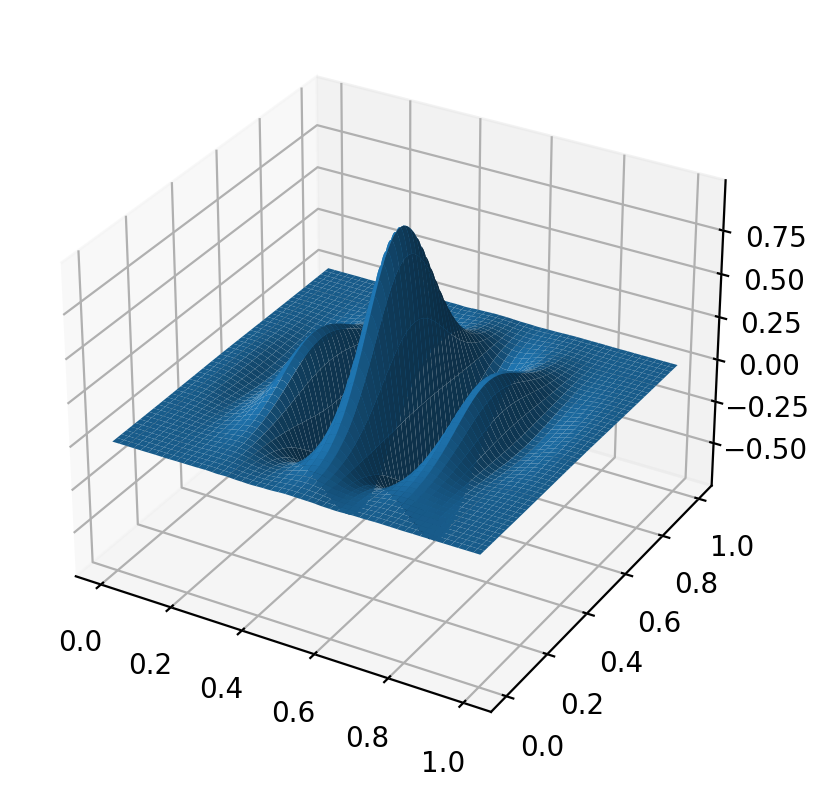

time taken:  819.0627760887146
neuron num 		 error 		 order
4 		 0.188179 		 * 		 5.693391 		 * 

8 		 0.188111 		 0.000524 		 5.693333 		 0.000015 

16 		 0.187412 		 0.005367 		 5.669143 		 0.006143 

32 		 0.121375 		 0.626746 		 4.171847 		 0.442444 

64 		 0.034842 		 1.800577 		 1.592777 		 1.389142 

128 		 0.005191 		 2.746640 		 0.370731 		 2.103099 

256 		 0.000739 		 2.811811 		 0.085751 		 2.112140 

512 		 0.000145 		 2.346454 		 0.023963 		 1.839332 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.188179 &		 * & 		 5.693391 & 		 *  \\ \hline  

8 		 &  1.881e-01 &  		 0.00 &  		 5.693e+00 &  		 0.00 \\ \hline  

16 		 &  1.874e-01 &  		 0.01 &  		 5.669e+00 &  		 0.01 \\ \hline  

32 		 &  1.214e-01 &  		 0.63 &  		 4.172e+00 &  		 0.44 \\ \hline  

64 		 &  3.484e-02 &  		 1.80 &  		 1.593e+00 &  		 1.39 \\ \hline  

128 		 &  5.191e-03 &  		 2.75 &  		 3.707e-01 &  		 2.10 \\ \hline  

256 		 &  7.393e-04 &  		

In [7]:
sigma = 0.15
m = 4 

def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term


def u_exact_grad():
    def u_grad_x(x):
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Derivative with respect to x_1
        du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)
        return du_dx1
        
    def u_grad_y(x):

        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])
        du_dx_other = exp_term * (-2 * (x[:, 1:2] - 0.5) / (2 * sigma ** 2)) * cos_term
        return du_dx_other

    u_grad=[] 
    u_grad.append(u_grad_x)
    u_grad.append(u_grad_y)
    return u_grad


def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""

    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(dim):
    u_grad = u_exact_grad() 
    bcs_N = []
    for i in range(dim):
        bcs_N.append((i, u_grad[i]))
    return bcs_N 

dim = 2 
function_name = "gabor2d-m4" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
Nx = 600  
order = 2 
f_write = open(filename_write, "a")
f_write.write("Numerical integration Nx: {}, order: {} \n".format(Nx, order))
f_write.close() 
save = True 
write2file = True 
memory = 2**29 
rand_deter = 'rand'
for N_list in [[2**4,2**5]]: # ,[2**6,2**6],[2**7,2**7] 
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 9 
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    relu_k = 3 
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU2D(my_model,rhs,u_exact, u_exact_grad,g_N, N_list,num_epochs,plot_freq, Nx, order, k = relu_k, rand_deter = rand_deter, linear_solver = "direct")
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_{}.pt'.format(function_name,num_epochs,N,rand_deter)
        torch.save(err_QMC2,filename) 
        filename = folder + 'err_h10_OGA_2D_{}_neuron_{}_N_{}_{}.pt'.format(function_name,num_epochs,N,rand_deter)
        torch.save(err_h10,filename) 
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_{}.pt'.format(function_name,num_epochs,N,rand_deter)
        torch.save(my_model,filename)

    show_convergence_order2(err_QMC2,err_h10,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex2(err_QMC2,err_h10,exponent)

## test Neumann problem

with neumann boundary conditon

In [ ]:
def test_neumann_problem_2d():
    # sine example 
    def u_exact(x):
        return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])  

    def u_exact_grad():
        def u_grad_x(x):
            return pi*torch.cos(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])
        def u_grad_y(x):
            return pi*torch.sin(pi*x[:,0:1])*torch.cos(pi*x[:,1:2]) 

        u_grad=[] 
        u_grad.append(u_grad_x)
        u_grad.append(u_grad_y)
        return u_grad

    def laplace_u_exact(x):
        return -2*pi**2 * torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2])

    def rhs(x):
        return -laplace_u_exact(x) + u_exact(x) 
    
    def g_N(dim):
        u_grad = u_exact_grad() 
        bcs_N = []
        for i in range(dim):
            bcs_N.append((i, u_grad[i]))
        return bcs_N

    # ## cosine example 
    # def u_exact(x):
    #     return torch.cos(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])  

    # def u_exact_grad():
    #     def u_grad_x(x):
    #         return -2*pi*torch.sin(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])
    #     def u_grad_y(x):
    #         return -2*pi*torch.cos(2*pi*x[:,0:1])*torch.sin(2*pi*x[:,1:2]) 

    #     u_grad=[] 
    #     u_grad.append(u_grad_x)
    #     u_grad.append(u_grad_y)
    #     return u_grad

    # def laplace_u_exact(x):
    #     return -2*(2*pi)**2 * torch.cos(2*pi*x[:,0:1])*torch.cos(2*pi*x[:,1:2])

    # def rhs(x):
    #     return -laplace_u_exact(x) + u_exact(x) 
    
    # def g_N(dim):
    #     return None 
    
    err_l2_list = [] 
    err_h10_list = []  
    weights, integration_points = PiecewiseGQ2D_weights_points(75, order = 3) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(50, d = 2)   
    for neuron_num in [4,8,16,32,64,128]: 
        my_model = model(2, neuron_num, 1, k = 1).to(device) 
        my_model = adjust_neuron_position(my_model)
        sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" )
        my_model.fc2.weight.data[0,:] = sol[:]
        # plot_2D(my_model)
        diff_sqrd = (my_model(integration_points).detach() - u_exact(integration_points))**2
        err_l2 = (weights.t() @ diff_sqrd)**0.5 
        err_l2_list.append(err_l2)
    print(err_l2_list)   
    return 0 

test_neumann_problem_2d() # passed! 

## test Newton solver 

In [ ]:

def test_nonlinear():
#     freq = 1
#     def u_exact(x):
#         return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
#     def u_exact_approx(x):
#         return torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])*0.5 
    
#     def u_exact_grad():
#         def u_grad_x(x):
#             return freq*pi*torch.cos(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2])
#         def u_grad_y(x):
#             return freq*pi*torch.sin(freq*pi*x[:,0:1])*torch.cos(freq*pi*x[:,1:2]) 

#         u_grad=[] 
#         u_grad.append(u_grad_x)
#         u_grad.append(u_grad_y)
#         return u_grad
    
#     def laplace_u_exact(x):
#         return -2*(freq*pi)**2 * torch.sin(freq*pi*x[:,0:1])*torch.sin(freq*pi*x[:,1:2]) 
#     def rhs(x):
#         return  -laplace_u_exact(x) + nonlinear(u_exact(x))

#     def g_N(dim):
#         u_grad = u_exact_grad() 
#         bcs_N = []
#         for i in range(dim):
#             bcs_N.append((i, u_grad[i]))
#         return bcs_N
    

    def u_exact(x):
        """Gabor function applied to a batch of points."""
        m = 8
        sigma = 0.15
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
        return exp_term * cos_term
    def u_exact_approx(x):
        return u_exact(x)*0.99 
    

    def u_exact_grad():
        def u_grad_x(x):
            m = 8
            sigma = 0.15
            exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
            cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
            sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

            # Derivative with respect to x_1
            du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)
            return du_dx1

        def u_grad_y(x):
            m = 8
            sigma = 0.15
            exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
            cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
            sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])
            du_dx_other = exp_term * (-2 * (x[:, 1:2] - 0.5) / (2 * sigma ** 2)) * cos_term
            return du_dx_other

        u_grad=[] 
        u_grad.append(u_grad_x)
        u_grad.append(u_grad_y)
        return u_grad


    def laplace_u_exact(x):
        m = 8
        sigma = 0.15
        """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Laplacian in x_1: Apply the product rule twice
        laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
        laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
        laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
        laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
        laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

        laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                    + laplace_x1_part_4 + laplace_x1_part_5

        # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
        laplace_other = (-1 / sigma ** 2) * exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term \
                    + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

        # Sum all Laplacians over each variable to get the total Laplacian
        laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

        return laplace_sum 

    def rhs(x):
        """Right-hand side of the equation using the Gabor function for a batch of points."""
        laplace_sum = laplace_u_exact(x)
        return -laplace_sum + nonlinear(u_exact(x))

    def g_N(dim):
        u_grad = u_exact_grad() 
        bcs_N = []
        for i in range(dim):
            bcs_N.append((i, u_grad[i]))
        return bcs_N 
    err_l2_list = [] 
    err_h10_list = []  
    weights, integration_points = PiecewiseGQ2D_weights_points(400, order = 3) 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(999999, d = 2)   
    for neuron_num in [16,32,64,128,256,512]: 
        my_model = model(2, neuron_num, 1, k = 3).to(device) 
        my_model = adjust_neuron_position(my_model)
        sol = minimize_linear_layer_explicit_assemble(my_model,u_exact_approx,weights, integration_points,solver="direct")
        # sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points,activation = 'relu', solver = 'direct')
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        sol = minimize_linear_layer_newton_method(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu',solver="direct" )
        my_model.fc2.weight.data[0,:] = sol[0,:]
        # plot_2D(my_model)
        diff_sqrd = (my_model(integration_points).detach() - u_exact(integration_points))**2
        err_l2 = (weights.t() @ diff_sqrd)**0.5 
        err_l2_list.append(err_l2)
    print(err_l2_list)   
    return 0 
    
test_nonlinear()